In [1]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner

In [2]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_Model/saras3_S11_200mm_above_water.s1p", skiprows=5))

d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
c=3*10**8  # speed of light (m/s)
freq=[d[i][0] for i in range(len(d)-1)] #frequency
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_Model/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()

In [3]:
def Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    
    l=l
    freq= [d[i][0] for i in range(len(d)-1)]
    for i in range(len(freq)):
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

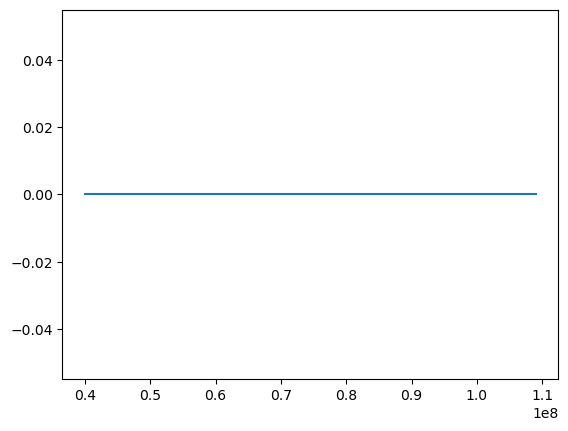

In [4]:
plt.plot(freq, Compute_Tmeas_(300,0,70,0.3,0.1,2))

In [5]:
def Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    freq= [d[i][0] for i in range(len(d)-1)]
    for i in range(len(freq)):
        gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

In [6]:
def Compute_Tmeas_RLC_exp(PA, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    global rlc
    freq= [d[i][0] for i in range(len(d)-1)]
    gamma_A=rlc
    for i in range(len(freq)):
        #print(gamma_A[i])
        #gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A[i])**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A[i])**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A[i])**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A[i])**2)*C))
    return(Tmeas)

# MCMC for Load

In [7]:
########## Define the log-likelihood function
def log_likelihood_l(params,**kwargs):
    PA, gamma_A, PN, gamma_N, f, l = params
    
    # Define the Expected TA values
    seed=kwargs["seed"]
    ip_params=kwargs["ip_params"]
    np.random.seed(seed)
    
    TA_exp = Compute_Tmeas_(*ip_params) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA
    TA_model = Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f,  l)
    TA_model=np.array(TA_model)

    # Compute chi-squared with weights
    s = kwargs["s"]  # Uncertainty
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s) #+ np.log(s**2) # Likelihood function

########## Define the log-prior function
def log_prior_l(params):
    
    PA, gamma_A, PN, gamma_N, f, l = params
 
    if ((0 <= gamma_A <= 1) and (0 <= gamma_N <= 1) and (100<=PA<=500) and (50<=PN<=150) and (0.05<=f<=0.5) and (0.05<l<5)) : 
            return 0.0  # Reject sample
    return -np.inf # Uniform prior

######### Define the full log-probability function

def log_probability_l(params,**kwargs):
    lp = log_prior_l(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_l(params,**kwargs)

########### MCMC

def evolve_MCMC_l(**kwargs):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]

    # Number of walkers and steps
    ndim = 6  # Number of parameters
    nwalkers = 250  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"]) #np.array(initial_value)
    
    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim)
    pos= initial_value[None,:] + initial_value*1e-2*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])

    def wrap_log_probability_l(params):
        return log_probability_l(params,**kwargs)
        
    ############ Set up the MCMC sampler
    sampler_l = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability_l, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler_l.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples_l=sampler_l.get_chain()
    samples_l = sampler_l.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes_l = np.array([log_likelihood_l(p, **kwargs) for p in samples_l])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes_l)
    
    ########## Get the best-fit parameters
    best_fit_params_l = samples_l[max_likelihood_index].tolist()

    return full_samples_l,samples_l,best_fit_params_l

In [8]:
#evolve MCMC
ip_params=[300,0,70,0.312,0.1,2] #input parameters
nsteps=3000
initials=[301.2, 0.02, 70.7, 0.29, 0.1, 1.95]
s=0.001
seed=61

kwargs={"nsteps": nsteps, "ip_params": ip_params, "initial_value": initials, "s":s, "seed":seed}

full_samples_l, samples_l, best_fit_params_l= evolve_MCMC_l(**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [09:03<00:00,  5.52it/s]


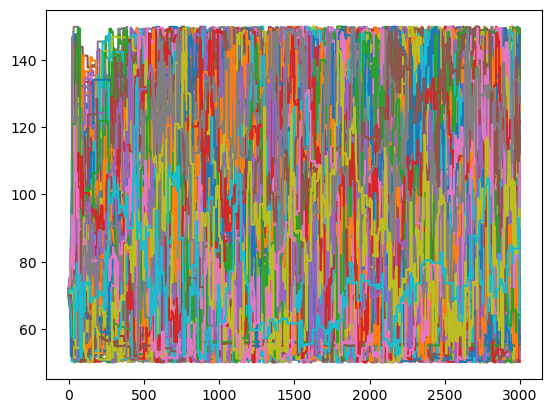

In [81]:
#samples.shape
plt.plot(full_samples_l[:,:,2])
plt.show()

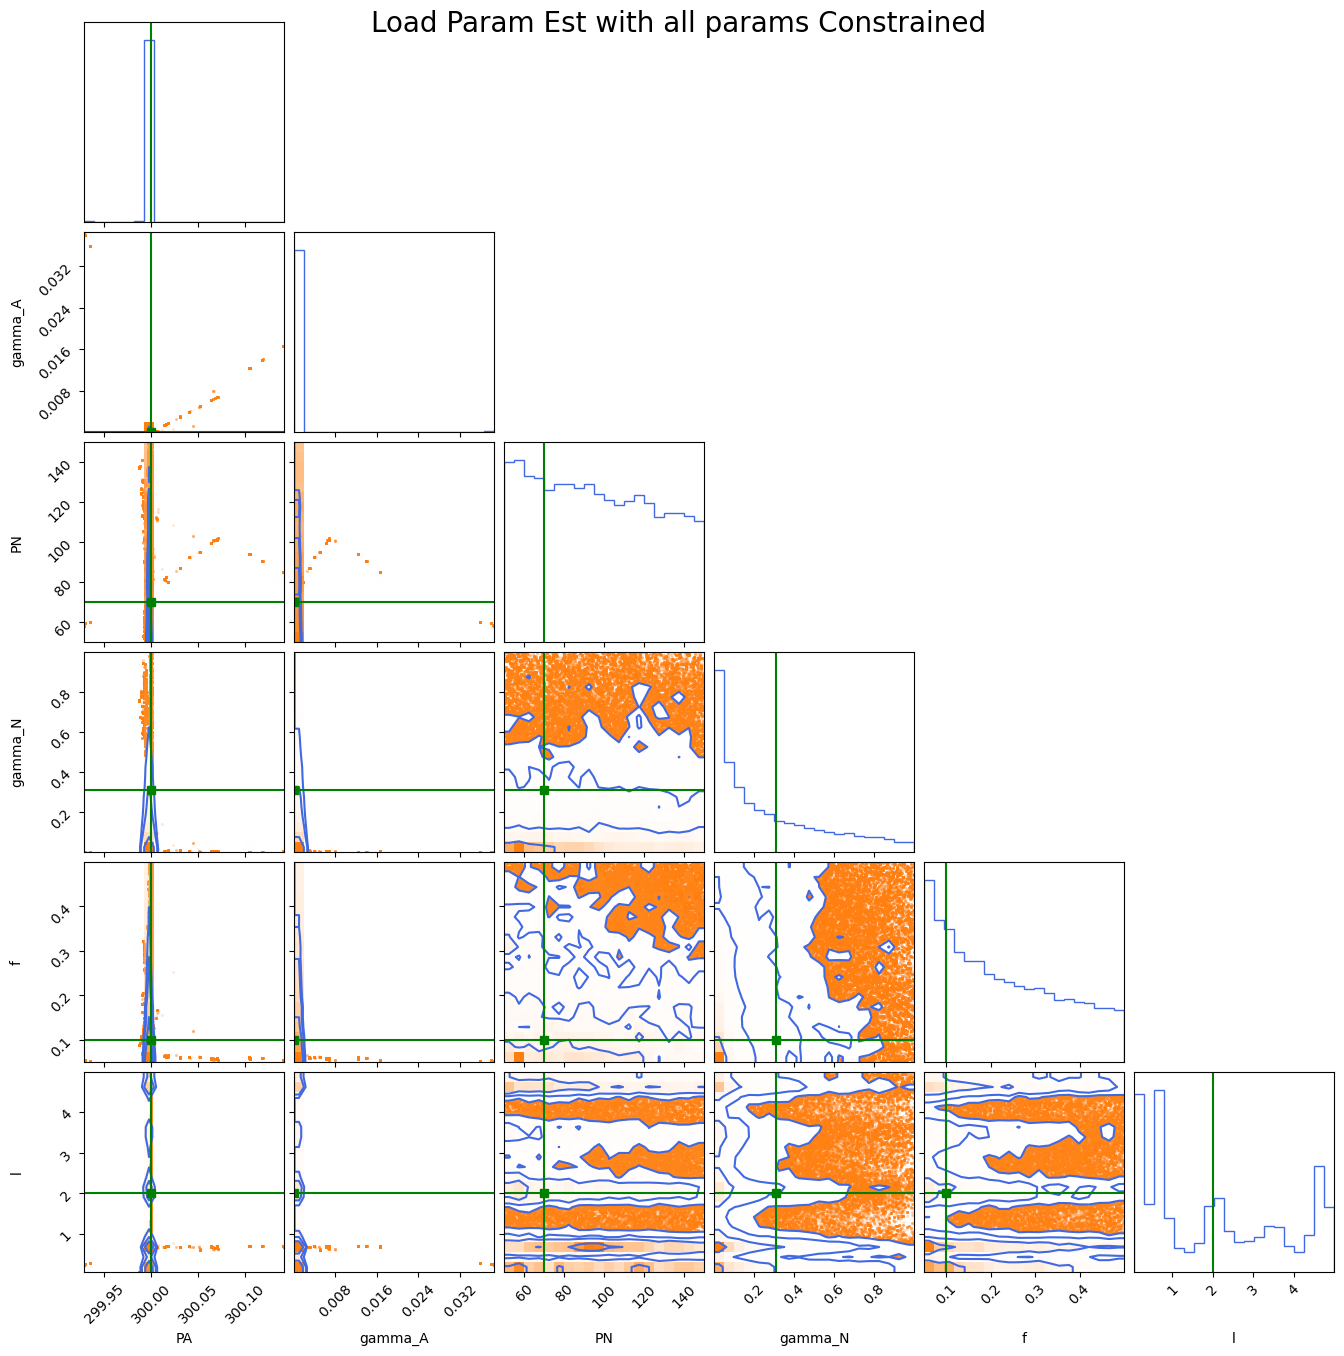

Best-fit parameters (Maximum Likelihood Estimate): [299.99982575355614, 2.8938479333665063e-07, 146.27146770007403, 0.9347513819627226, 0.22683545023755808, 4.693574670975099]


In [9]:
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_l, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Load Param Est with all params Constrained", fontsize=20)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/Load_all_2m_4.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_l)

In [99]:
#creating a CSV for storing the best fit parameters
data=[["PA", "gamma_A", "PN", "gamma_N", "f","l"],
      [i for i in ip_params],
      [round(p, 2) for p in best_fit_params_l]]
priors=["Priors: gA, gN, PA, PN, f, L  & seed: "+str(seed)]
sd=[str(seed)]
with open('Estimated_params_load.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    #writer.writerow(sd)
    writer.writerows(data)
    
print([round(p, 2) for p in best_fit_params_l])  

[300.0, 0.0, 53.43, 0.07, 0.12, 4.69]


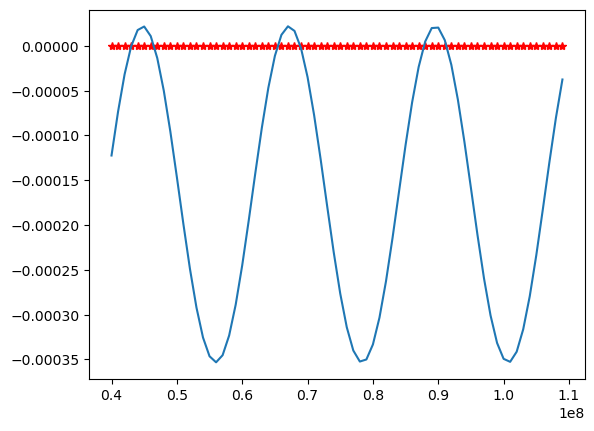

In [97]:
#Reconstructing TA 
TA_exp_l=Compute_Tmeas_(300.0, 0.0, 89.23, 0.28, 0.32, 3.45)#0,1,70,0.3,0.1,2)
op_params=best_fit_params_l
TA_mod_l=Compute_Tmeas_(*op_params)
plt.plot(freq,TA_exp_l,"*r")
plt.plot(freq,TA_mod_l)

## Joint MCMC for Open and Load with Load initials

In [10]:
########## Define the log-likelihood function
def log_likelihood(params, **kwargs):
    
    ip_params=kwargs["ip_params"]
    PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l = ip_params
    
    seed=kwargs["seed"]
    np.random.seed(seed)
    
    # Define the Expected TA values for open
    TA_exp_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_o=np.array(TA_exp_o)
    
    # Define the Expected TA values for Load
    TA_exp_l = Compute_Tmeas_(PAl, gamma_Al, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_l=np.array(TA_exp_l)


    PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l = params
    
    # Compute model TA for open
    TA_model_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l)
    TA_model_o=np.array(TA_model_o)

    # Compute model TA for load
    TA_model_l = Compute_Tmeas_(PAl, gamma_Al, PN, gamma_N, f, l)
    TA_model_l=np.array(TA_model_l)
    
    
    s = kwargs["s"] # Uncertainty
    
    # Compute chi-squared for Open
    
    chi2_o = np.sum([((TA_exp_o - TA_model_o)/s)** 2 ]) 
    
    # Compute chi-squared for Load
    
    chi2_l = np.sum([((TA_exp_l - TA_model_l)/s)** 2 ]) 

    # Likelihood function
    Likelihood= -0.5*chi2_o - 0.5*chi2_l - 2*np.log(math.sqrt(2*np.pi)*s) 
    return Likelihood

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l = params
    v=kwargs["v"]
    #gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    #if (np.all((gamma_A >= 0) & (gamma_A <= 1)) and (0<=gamma_Ao<=1) and (0<=gamma_N<=1) and (0.05<l<5)):
        #return 0.0  # Uniform prior
    return 0.0 #-np.inf #reject
          

######### Define the full log-probability function

def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)

########### MCMC

def evolve_MCMC_Joint_OL(**kwargs):# Define parameter names
 
    # Number of walkers and steps
    ndim = 8 # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    ## Starting positions for the walkers
    pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [13]:
# Evaluate MCMC
s=0.001
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
PAo,gamma_Ao=[0.03,0.99]
PAl, gamma_Al, PN, gamma_N, f, l = best_fit_params_l
seed=18
ip_params=[0, 1, 300, 0, 70, 0.3, 0.1, 2]
initials=[PAo, gamma_Ao, PAl, gamma_Al, PN, gamma_N, f, l ]

kwargs={"nsteps":nsteps, "ip_params":ip_params,"initial_value": initials, "s":s, "v":v, "seed":seed}

full_samples_OL, samples_OL, best_fit_params_OL= evolve_MCMC_Joint_OL(**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [25:34<00:00,  1.96it/s]


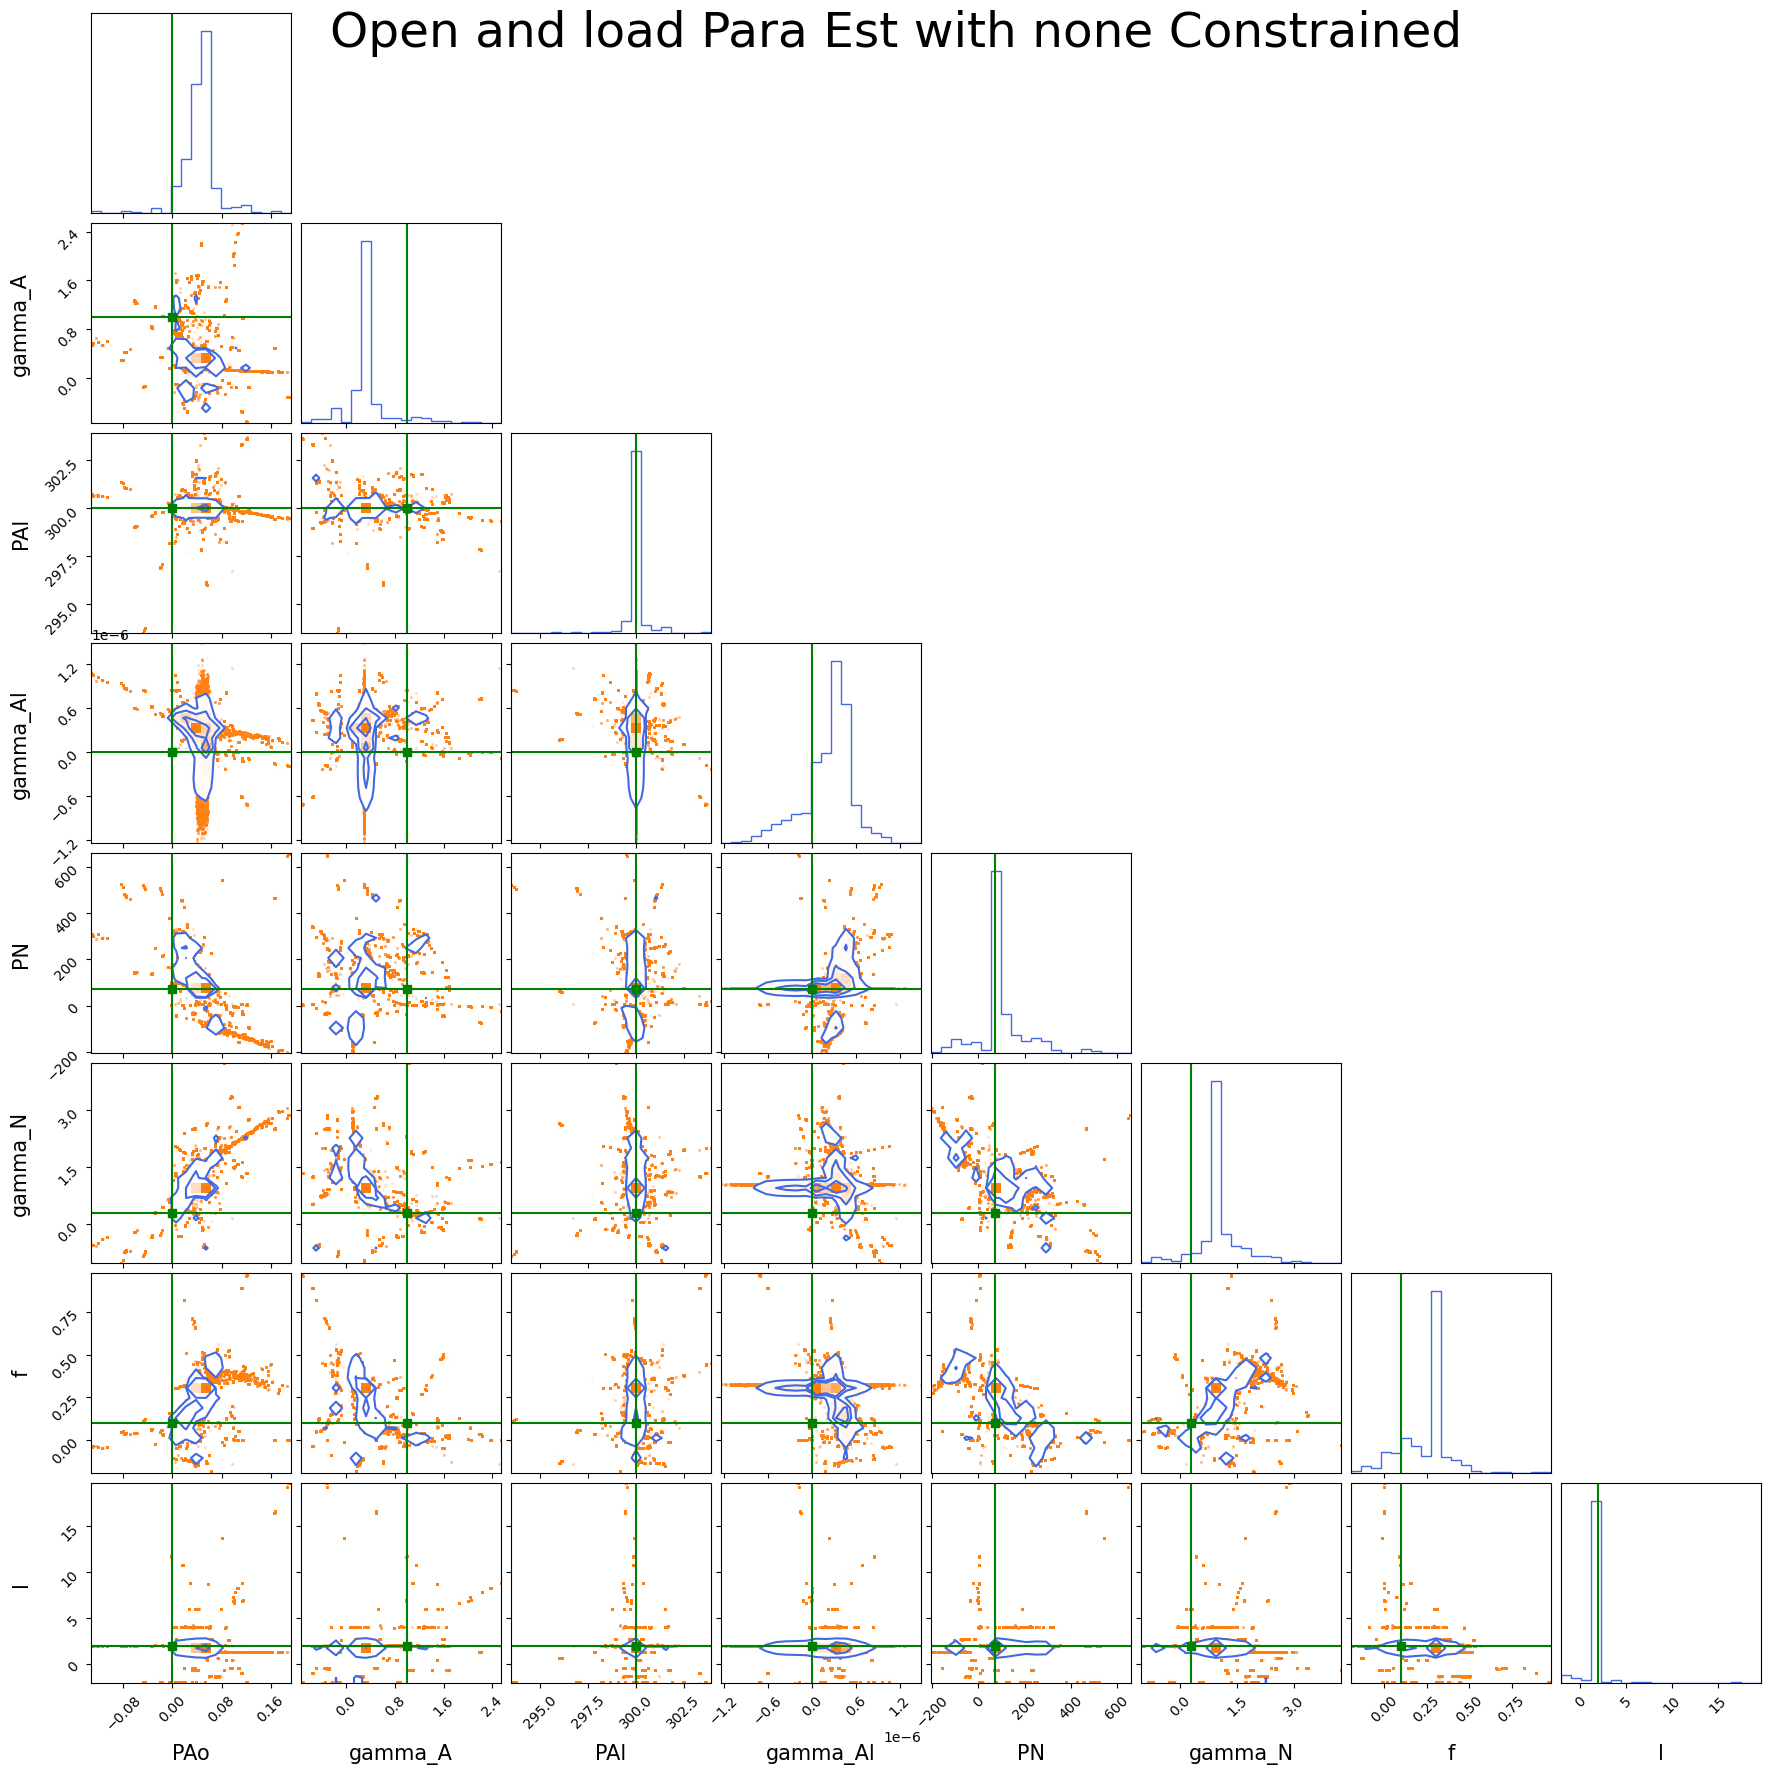

Best-fit parameters (Maximum Likelihood Estimate): [0.041014419410529857, 0.28893484540182773, 300.00021808766905, -3.515749080152102e-07, 74.34375303608773, 1.0383094483926563, 0.3258705270417144, 2.0000014482985544]


In [14]:
parameter_names = ["PAo", "gamma_A", "PAl", "gamma_Al", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_OL, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Open and load Para Est with none Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/Load_Open_none_2m.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_OL)

## MCMC for RLC coeffs with fixed params from load

In [95]:
########## Define the log-likelihood function
def log_likelihood(ip_params,params,**kwargs):

    #PA = kwargs["PA"]
    PN = kwargs["PN"]
    gamma_N = kwargs["gamma_N"]
    f = kwargs["f"]
    l = kwargs["l"]
    #ip_params = args["ip_params"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    #print(PA,ip_params)

    # Compute TA expected
    
    PA, p0, p1, p2, p3, p4, p5, p6 = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6 = params
    TA_model = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):

    ## Define bounds for parameters
    #min_values = [ -6,  1, -5,  3.8, -2.5,  4.5,  4]
    #if type=='open' or type=='short':
    #max_values= [-5,  3, -4,  4.8, -1.8,  5.5,  5] 
    
    PA, p0, p1, p2, p3, p4, p5, p6 = params
    
    #for p, min_v, max_v in zip(params, min_values, max_values):
        #if not (min_v <= p <= max_v):
            #return -np.inf  # Reject sample

    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if np.all((gamma_A >= 0) & (gamma_A <= 1)) and (250<PA<350):
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(ip_params,params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(ip_params,params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_RLC(ip_params,nsteps, initial_value,**kwargs):
    
    # Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    ## Number of walkers and steps
    
    ndim = 8  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=initial_value

    ## Starting positions for the walkers
    
    pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(ip_params, params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(ip_params,p,**kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [96]:
PA=300
s=0.001
seed=15
v=[d[i][0] for i in range(len(d)-1)]

PA_l, gamma_Al, PN, gamma_N, f, l=best_fit_params_l
kwargs={"PN":PN,  "gamma_N":gamma_N, "f":f, "l":l, "s":s, "v":v, "seed":seed}
ip_params=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]
initials=[301, -6,  2.4, -4.1,  4.0, -1.96,  4.7,  4.5]

full_samples_rlc, samples_rlc, best_fit_params_rlc= evolve_MCMC_RLC(ip_params=ip_params, nsteps=nsteps, initial_value=initials, **kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [07:51<00:00,  6.37it/s]


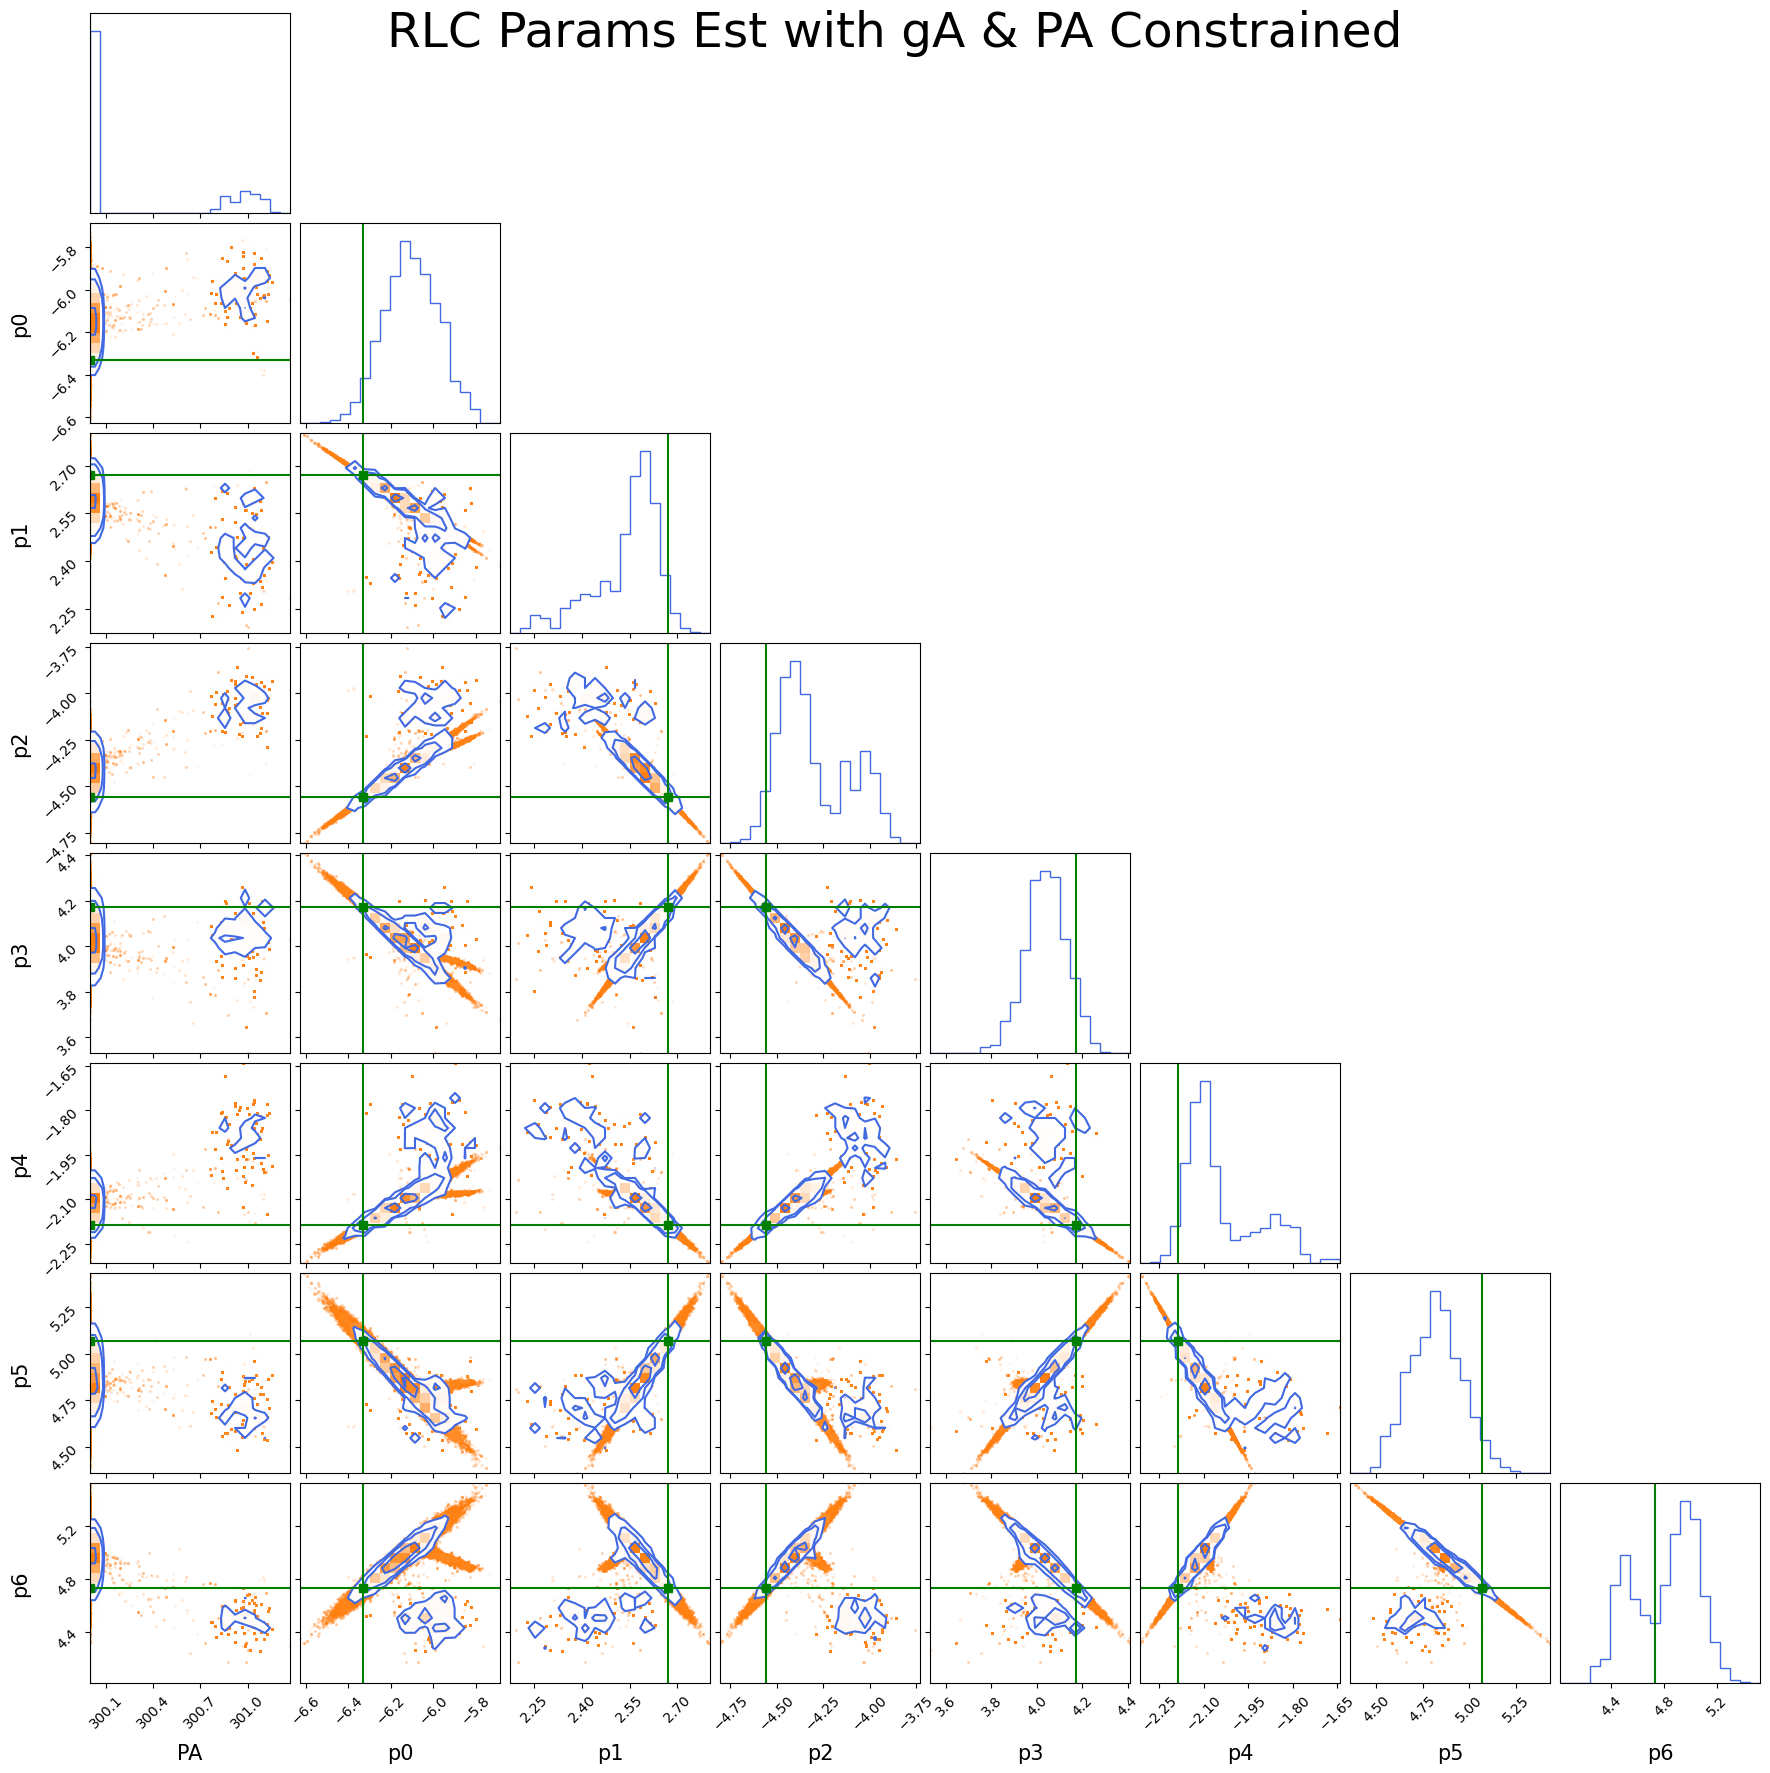

Best-fit parameters (Maximum Likelihood Estimate): [299.9999462934678, -6.202382033591709, 2.6133331337422936, -4.456703660603314, 4.071097361101479, -2.1335608726604045, 4.924123010740818, 4.896061846331963]


In [98]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6"]
#corner plot 
fig = corner.corner(samples_rlc, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("RLC Params Est with gA & PA Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_gA_PA_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_rlc)

In [35]:
#creating a CSV for storing the best fit parameters
data=[['PArlc','p0','p1','p2','p3','p4','p5','p6'],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_rlc]]
priors=["Priors: gA,L & seed: "+str(seed)]
sd=[str(seed)]
with open('Estimated_params_rlc.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    #writer.writerow(sd)
    writer.writerows(data)
    
print(seed) 

1


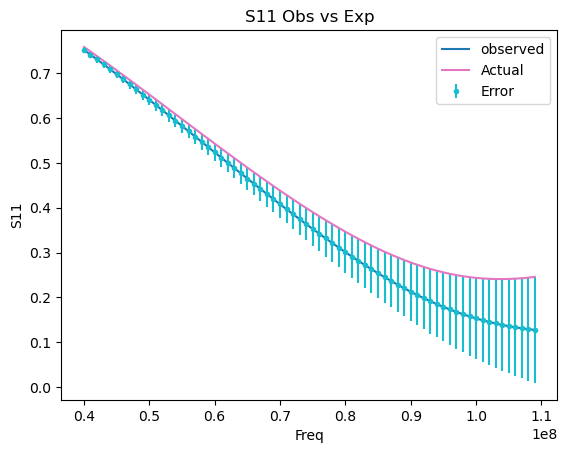

In [36]:
#Reconstruction 
PA, p0, p1, p2, p3, p4, p5, p6=best_fit_params_rlc
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
#plt.plot(v,gamma_rlc, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_S11_gA_L.png', dpi=300)

## MCMC for RLC with load as Initials

In [61]:
########## Define the log-likelihood function
def log_likelihood(ip_params,params,**kwargs):

    #PA = kwargs["PA"]
    #PN = kwargs["PN"]
    #gamma_N = kwargs["gamma_N"]
    #f = kwargs["f"]
    #l = kwargs["l"]
    #ip_params = args["ip_params"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    #print(PA,ip_params)

    # Compute TA expected
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_RLC_exp(PA,PN,gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):

    ## Define bounds for parameters
    #min_values = [ -6,  1, -5,  3.8, -2.5,  4.5,  4]
    #if type=='open' or type=='short':
    #max_values= [-5,  3, -4,  4.8, -1.8,  5.5,  5] 
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    
    #for p, min_v, max_v in zip(params, min_values, max_values):
        #if not (min_v <= p <= max_v):
            #return -np.inf  # Reject sample

    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    #if np.all((gamma_A >= 0) & (gamma_A <= 1)) and (250<PA<350):
        #return 0.0  # Uniform prior
    return 0.0 #-np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(ip_params,params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(ip_params,params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_RLC(ip_params,nsteps, initial_value,**kwargs):
    
    # Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    ## Number of walkers and steps
    
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=initial_value

    ## Starting positions for the walkers
    
    pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(ip_params, params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(ip_params,p,**kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [62]:
PA=300
s=0.001
seed=13
v=[d[i][0] for i in range(len(d)-1)]

PA_l, gamma_Al, PN, gamma_N, f, l=best_fit_params_l
#PA_o, gamma_Ao, PN, gamma_N, f, l=[0, 1, 70, 0.3, 0.1, 1]
kwargs={"s":s, "v":v, "seed":seed} #"PN":PN,  "gamma_N":gamma_N, "f":f, "l":l,
ip_params=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 1]
initials=[PA_l, -6,  2.4, -4.1,  4.0, -1.96,  4.7,  4.5, PN, gamma_N, f, l]

full_samples_rlc_1, samples_rlc_1, best_fit_params_rlc_1= evolve_MCMC_RLC(ip_params=ip_params, nsteps=nsteps, initial_value=initials, **kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [14:54<00:00,  3.35it/s]


In [ ]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6","PN","gamma_N","f","l"]
#corner plot 
fig = corner.corner(samples_rlc_1, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("RLC Params Est with none Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_2_none_.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_rlc_1)

## Full RLC+Open with Load as initials

In [63]:
########## Define the log-likelihood function
def log_likelihood(ip_params, params, **kwargs):
    
    PAl, gamma_Al, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    seed=kwargs["seed"]
    np.random.seed(seed)
    
    # Define the Expected TA values for open
    TA_exp_l = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_l=np.array(TA_exp_l)

    # Define the Expected TA values for RLC
    TA_exp_rlc = Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp_rlc=np.array(TA_exp_rlc)

    PAl, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    
    # Compute model TA for open
    TA_model_l = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l)
    TA_model_l=np.array(TA_model_l)

    # Compute model TA for open
    TA_model_rlc = Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    TA_model_rlc=np.array(TA_model_rlc)
    
    # Compute chi-squared for open
    s = kwargs["s"] # Uncertainty
    chi2_l = np.sum([((TA_exp_l - TA_model_l)/s)** 2 ]) 

    # Compute chi-squared for RLC
    s = kwargs["s"]  # Uncertainty
    chi2_rlc = np.sum([((TA_exp_rlc - TA_model_rlc)/s)** 2 ]) 

    # Likelihood function
    Likelihood= -0.5*chi2_l-0.5*chi2_rlc-2*np.log(math.sqrt(2*np.pi)*s) 
    return Likelihood

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    PAl, gamma_Al, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    """
    # Check if params are within bounds
    if 0.0 < PA < 5 and 0.0 < gamma_A < 1.0 and 5.0 < PN < 100.0 and 0.0 < gamma_N < 1.0 and 0.05 < f < 0.9 and 0.1 < l < 1.0:
        return 0.0
    return -np.inf
    """
    v=kwargs["v"]
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if np.all((gamma_A >= 0) & (gamma_A <= 1)) and (0<=gamma_Al<=1) and (0<=gamma_N<=1):
        return 0.0  # Uniform prior
    return -np.inf #reject
          

######### Define the full log-probability function

def log_probability(ip_params,params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(ip_params,params,**kwargs)

########### MCMC

def evolve_MCMC_Joint(ip_params, nsteps, initial_value,**kwargs):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]

    # Define bounds for parameters
    """
    min_values = [0.0, 0.0, 50.0, 0.0, 0.05,0.05]
    if type=='open' or type=='short':
        max_values= [5, 1, 150, 1,0.5, 13] 
    else:
        max_values = [350, 1, 150, 1, 0.5, 13] #maximum value of mass being scanned for load terminal
    """
    

    # Number of walkers and steps
    ndim = 14  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(initial_value)
    
    ## Starting positions for the walkers
    pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability(params):
        return log_probability(ip_params, params, **kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(ip_params, p,**kwargs) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [38]:
#PA=300
s=0.001
v=[d[i][0] for i in range(len(d)-1)]
PA_l,gamma_Al,PN,gamma_N,f,l=best_fit_params_l
PArlc, p0, p1, p2, p3, p4, p5, p6= best_fit_params_rlc
seed=13
kwargs={"s":s, "v":v, "seed":seed}
ip_params=[0, 1, 300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 1]
initials=[0.1, 0.97, 301, -6.21,  2.53, -4.37,  4.0, -2.09,  4.98,  4.67, 70.5, 0.29, 0.099, 0.98]

full_samples, samples, best_fit_params_joint= evolve_MCMC_Joint(ip_params=ip_params, nsteps=nsteps, initial_value=initials,**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [10:58<00:00,  4.56it/s]


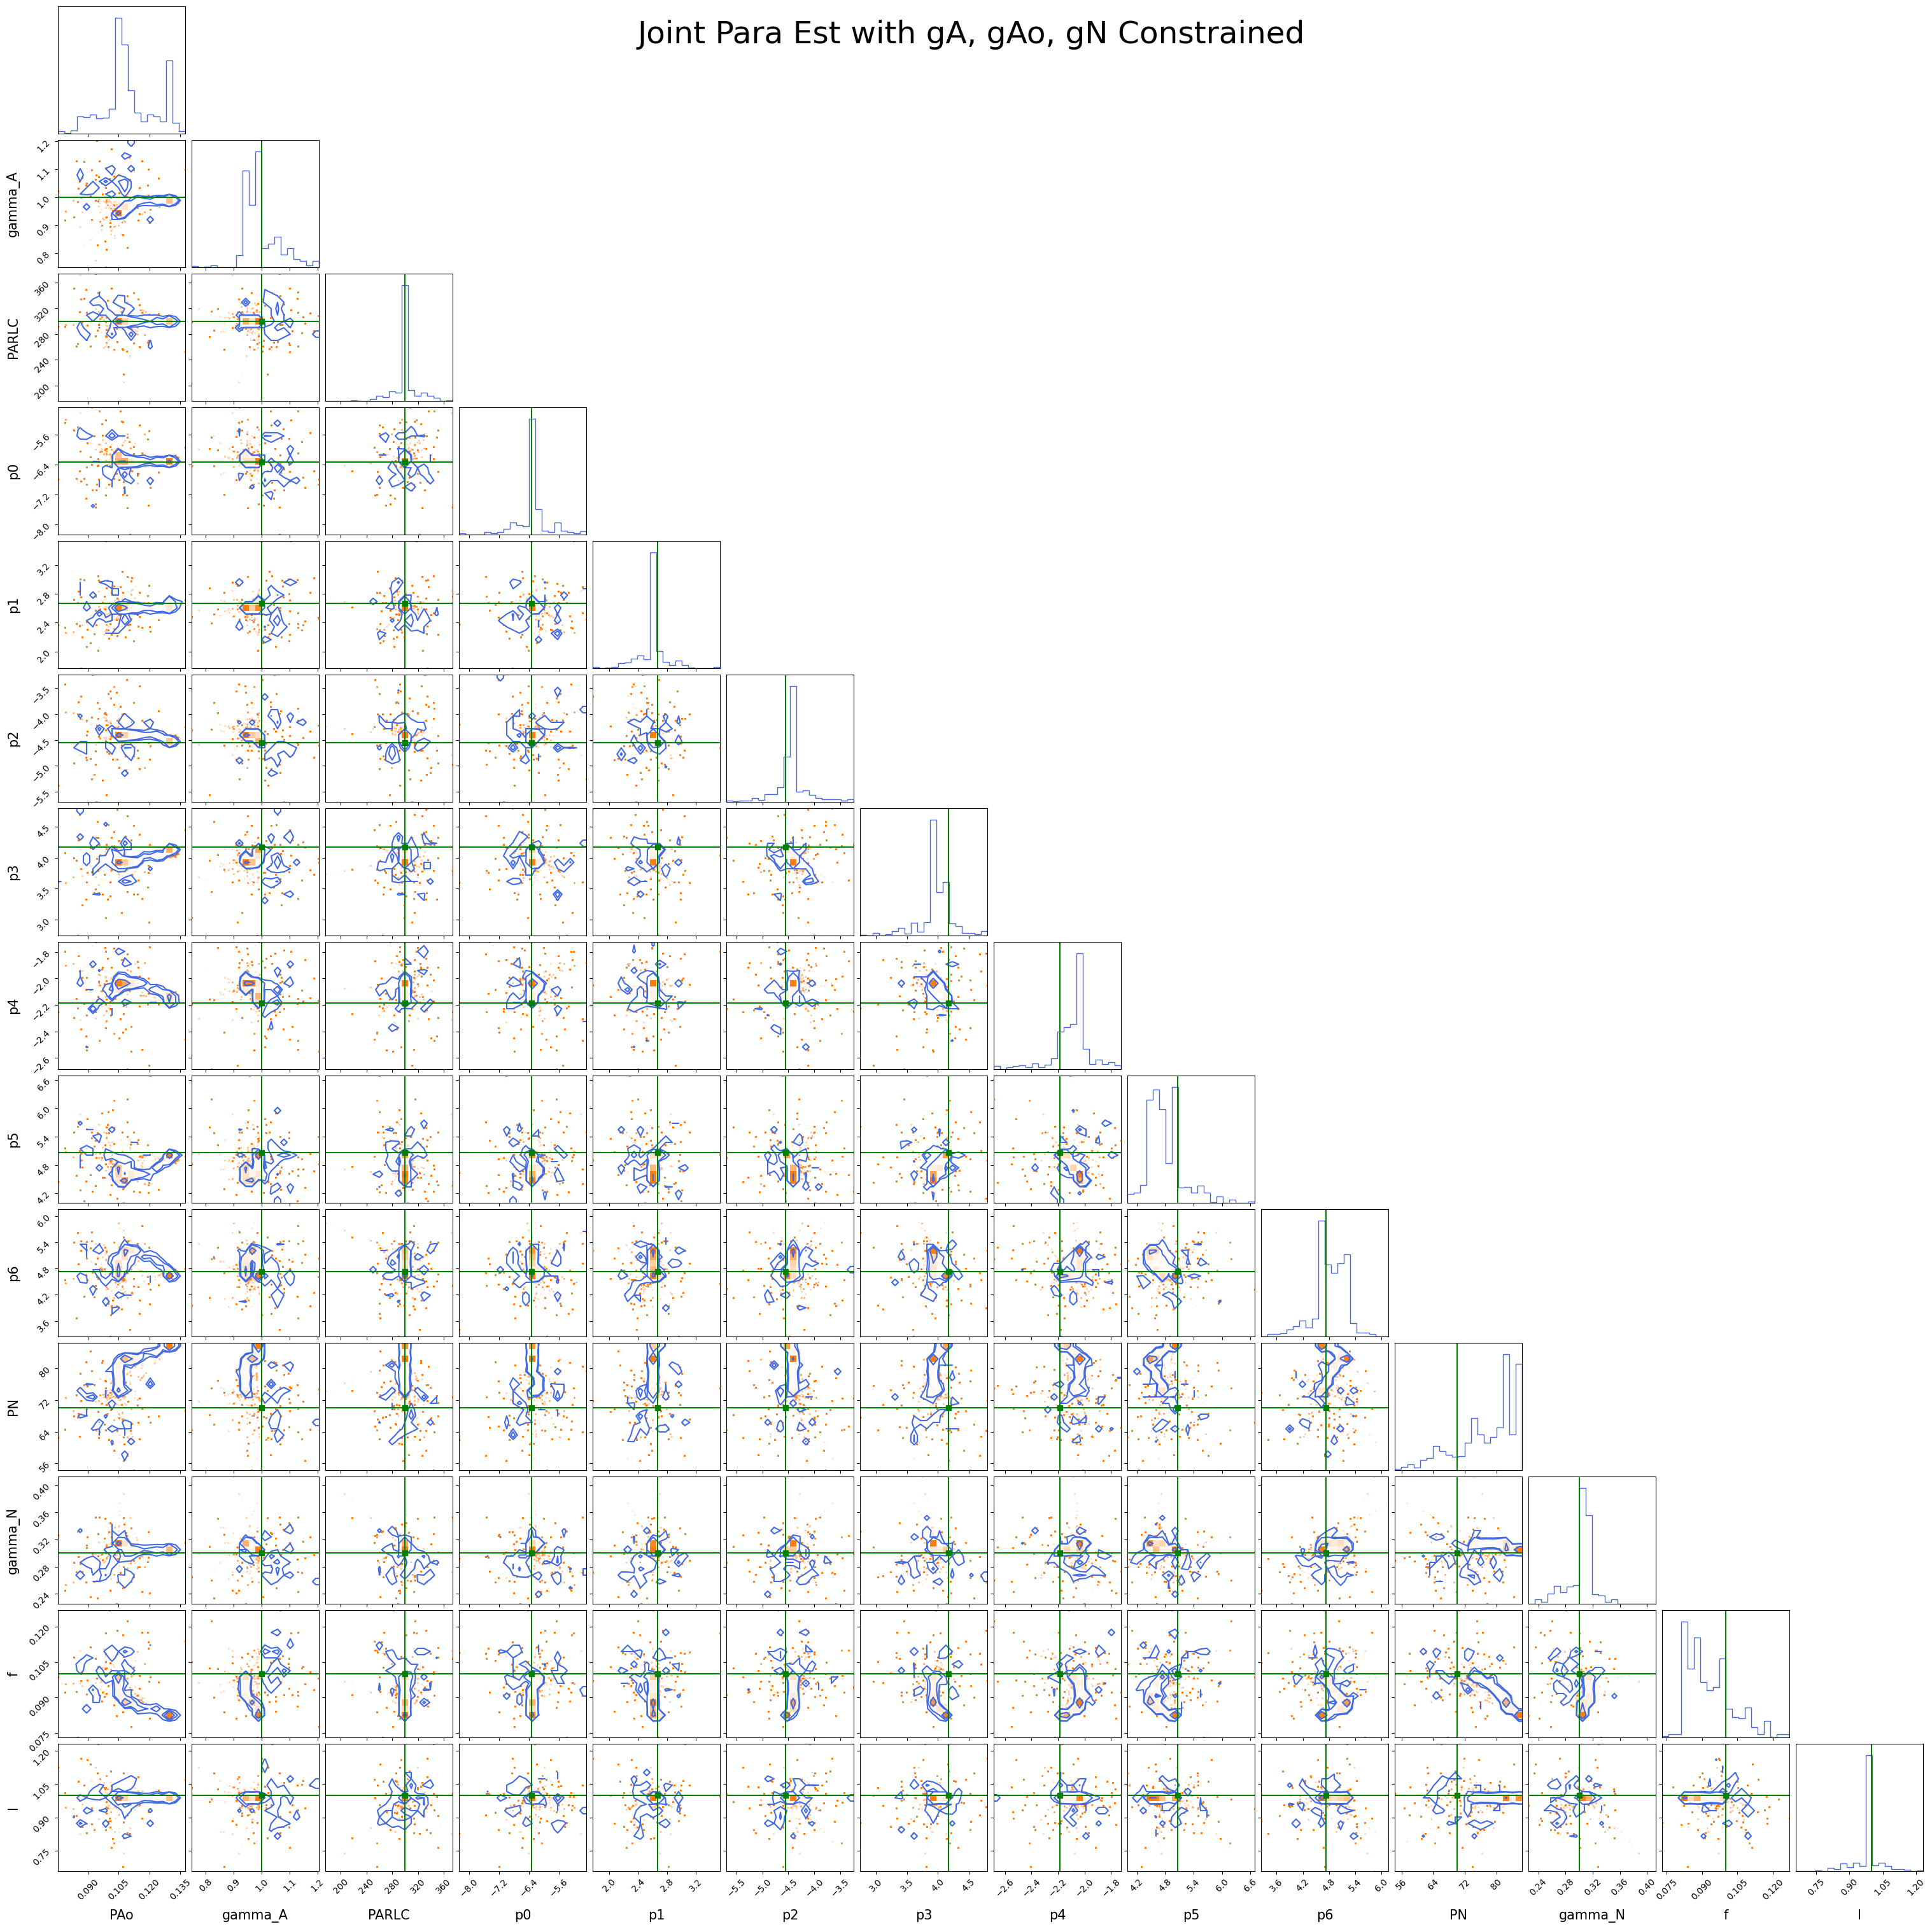

Best-fit parameters (Maximum Likelihood Estimate): [0.1303087434159034, 0.9822010974623506, 300.0129281101643, -6.1872959733652335, 2.604890411862406, -4.4379953419232585, 4.047629866863036, -2.1168960256853144, 4.885760297278533, 4.754786500524611, 85.97233644217457, 0.30542101285336354, 0.08289679873409342, 0.9999958984272506]


In [39]:
parameter_names = ["PAo", "gamma_A", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Joint Para Est with gA, gAo, gN Constrained", fontsize=35)
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Joint_ORLC_gA_gAo_gN_.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_joint)

In [41]:
#creating a CSV for storing the best fit parameters
data=[["PAo", "gamma_A", "PARLC", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_joint]]
priors=["Priors: gA, gAo,gN & seed: "+str(seed)]
sd=[str(seed)]
with open('Estimated_params_joint.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    #writer.writerow(sd)
    writer.writerows(data)
    
print(seed) 

13


[-6.1872959733652335, 2.604890411862406, -4.4379953419232585, 4.047629866863036, -2.1168960256853144, 4.885760297278533, 4.754786500524611]


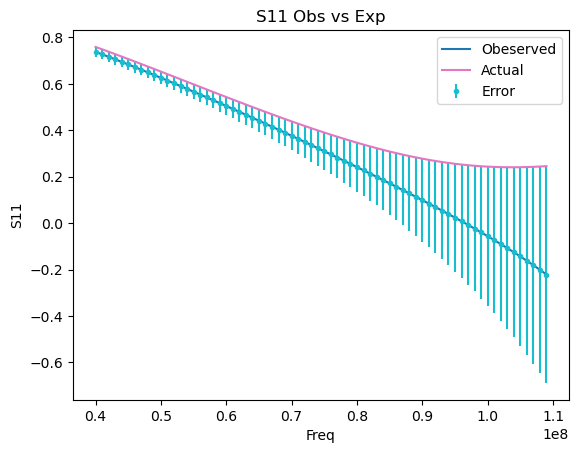

In [44]:
#Reconstructed S11

#Loading S11(RLC) and Frequency values
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_Model/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
v=[d[i][0] for i in range(len(d)-1)]
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_Model/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()

po,p1,p2,p3,p4,p5,p6=best_fit_params_joint[3:10]#[-5.910912507589248, 2.689859270112693, -4.2884083289057475, 3.7694946183104294, -2.205958605038012, 5.249384836575267, 4.849920668113429]#[ -5.848759259359305, 2.4598332012042574, -4.186166717966329, 3.8161924540424925, -1.9969916868948934, 4.5947110865421585, 4.7008405224259295]
#[-6.274954869166671, 2.716009717976181, -4.6891133131425535, 4.149936149195398, -2.270563185191849, 4.867143968582065, 4.753308867794712]
#p6,p5,p4,p3,p2,p1,p0=
print(best_fit_params_joint[3:10])
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Joint_ORLC_S11_gA_gAo_gN.png', dpi=300)

Text(0.5, 1.0, 'TA vs Freq for RLC')

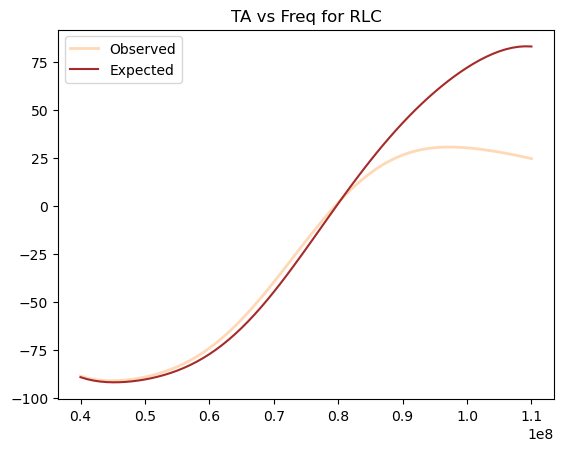

In [45]:
#PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = best_fit_params
PAo, gamma_Ao, PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= best_fit_params_joint
Ta=Compute_Tmeas_RLC(PArlc, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
ip_params=[300,-6.33,  2.67, -4.56,  4.2, -2.2,  5.1,  4.7, 70, 0.3, 0.1, 1]
TA=Compute_Tmeas_RLC(*ip_params)
v=[d[i][0] for i in range(len(d))]
plt.plot(v,Ta,label='Observed', color='C1',alpha=0.3, lw=2)
plt.plot(v,TA,label='Expected', color='brown')
plt.legend()
plt.title('TA vs Freq for RLC')
#plt.savefig('/Users/gopipatel/Desktop/Comparision_plot_2m.png', dpi=300)